In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, lax, grad, config, jacfwd
import equinox as eqx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

from JaxCMB import main, cosmology, perturbations
from JaxCMB.hyrax import hyrax

In [3]:
model = main.Model(lensing=False, has_MasslessNeutrinos=False, has_MassiveNeutrinos=False)

In [4]:
BG = cosmology.MockBackground()

In [5]:
PE = perturbations.PerturbationEvolver(model.perturbations_list, BG)

In [11]:
f = eqx.filter_jit(PE.full_evolution)
for i in range(3):
    s = time.time()
    PT = f()
    PT.theta_b.block_until_ready()
    print(time.time()-s)

16.232471227645874
16.24137854576111
16.229517936706543


In [81]:
f = eqx.filter_jit(PE.full_evolution_scan)
for i in range(1):
    s = time.time()
    PT = f()
    PT.theta_b.block_until_ready()
    print(time.time()-s)

12.422615051269531


In [ ]:
print(BG)

# Comparison to CLASS

In [138]:
# RSA on time
def rsa_on(k):
        # thresholds
        thr1 = 5      # tight_coupling_trigger_tau_c_over_tau
        thr2 = 45     # tight_coupling_trigger_tau_over_tau_k

        # 2) Ending lna
        lna_end_range = jnp.linspace(-8, 0., 5000)

        # a) τc/τ 
        f1 = BG.tau_c(lna_end_range) /BG.tau(lna_end_range)
        lna1 = jnp.interp(thr1, f1, lna_end_range) 

        # b) τ/τk  
        f2 = k * BG.tau(lna_end_range)
        lna2 = jnp.interp(thr2, f2, lna_end_range)

        lna_on = jnp.maximum(lna1, lna2)

        return lna_on

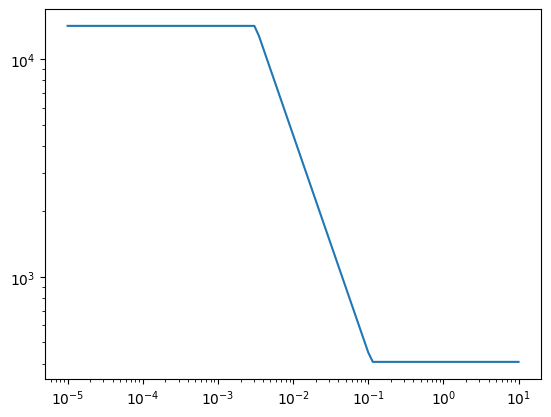

In [140]:
k = jnp.geomspace(1.e-5, 10, 100)
lna_on = vmap(rsa_on)(k)
plt.loglog(k, BG.tau(lna_on))
plt.show()

In [191]:
# Load CLASS
path = "/home/zz1994/packages/class/output/ABCMB_test/noneutrinos02"
k0 = np.loadtxt(path+"_perturbations_k0_s.dat")
k1 = np.loadtxt(path+"_perturbations_k1_s.dat")
k2 = np.loadtxt(path+"_perturbations_k2_s.dat")
ks = (k0, k1, k2)

In [192]:
ki = 2
k = PT.k[ki]
_, lna_tca_off = PE.get_tca_on_off(k)
lna_rsa_on = rsa_on(k)

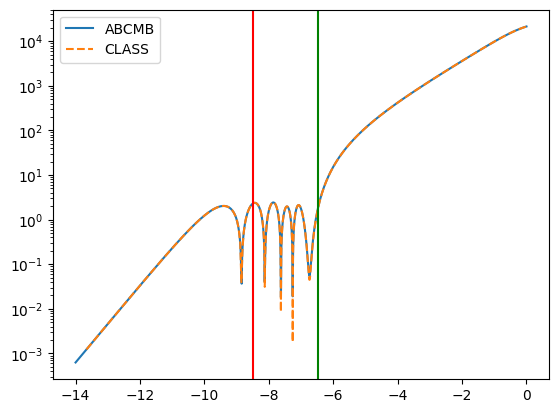

In [193]:
plt.plot(PT.lna, abs(PT.delta_b[:, ki]), label="ABCMB")
a = ks[ki][:, 1]
mode = ks[ki][:, 8]
plt.plot(jnp.log(a), abs(mode), "--", label="CLASS")
plt.axvline(lna_tca_off,  color="red")
plt.axvline(lna_rsa_on, color="green")
#plt.xlim((-15., -7.0))
plt.yscale("log")
plt.legend()
plt.show()

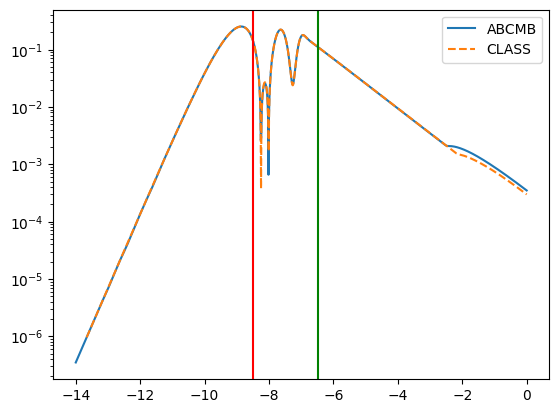

In [194]:
plt.plot(PT.lna, abs(PT.theta_b[:, ki]), label="ABCMB")
a = ks[ki][:, 1]
mode = ks[ki][:, 9]
plt.plot(jnp.log(a), abs(mode), "--", label="CLASS")
plt.axvline(lna_tca_off,  color="red")
plt.axvline(lna_rsa_on, color="green")
#plt.xlim((-15., -7.0))
plt.yscale("log")
plt.legend()
plt.show()

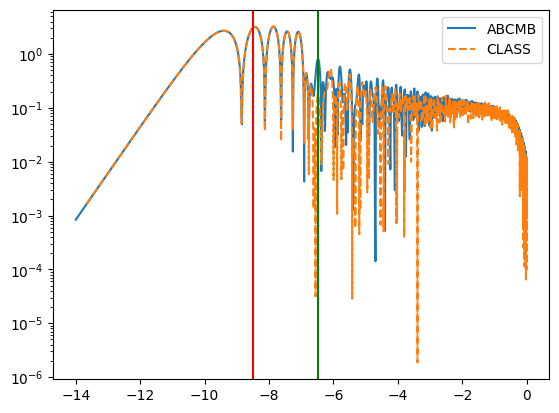

In [195]:
plt.plot(PT.lna, abs(PT.delta_g[:, ki]), label="ABCMB")
a = ks[ki][:, 1]
mode = ks[ki][:, 2]
plt.plot(jnp.log(a), abs(mode), "--", label="CLASS")
plt.axvline(lna_tca_off,  color="red")
plt.axvline(lna_rsa_on, color="green")
#plt.xlim((-15., -7.0))
plt.yscale("log")
plt.legend()
plt.show()

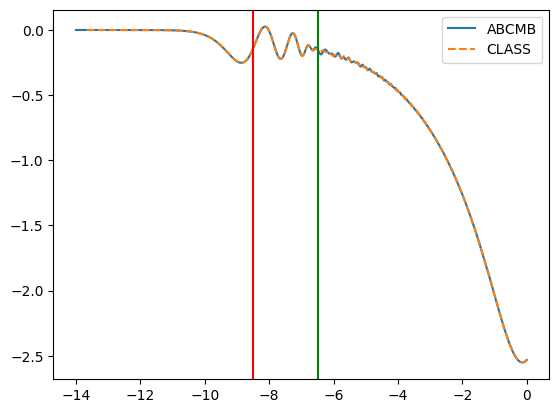

In [196]:
plt.plot(PT.lna, PT.theta_g[:, ki], label="ABCMB")
a = ks[ki][:, 1]
mode = ks[ki][:, 3]
plt.plot(jnp.log(a), mode, "--", label="CLASS")
plt.axvline(lna_tca_off,  color="red")
plt.axvline(lna_rsa_on, color="green")
#plt.xlim((-15., -7.0))
#plt.yscale("log")
plt.legend()
plt.show()

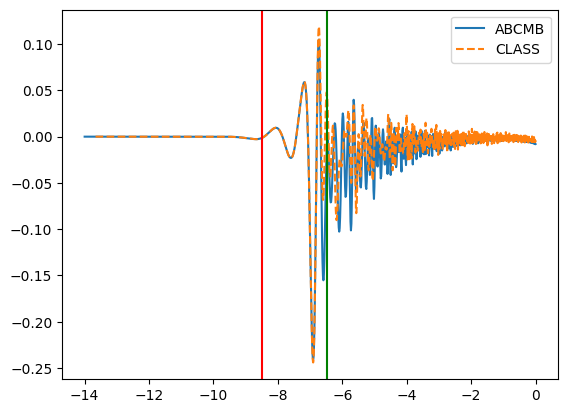

In [197]:
plt.plot(PT.lna, PT.sigma_g[:, ki], label="ABCMB")
a = ks[ki][:, 1]
mode = ks[ki][:, 4]
plt.plot(jnp.log(a), mode, "--", label="CLASS")
plt.axvline(lna_tca_off,  color="red")
plt.axvline(lna_rsa_on, color="green")
#plt.xlim((-15., -7.0))
#plt.yscale("log")
plt.legend()
plt.show()

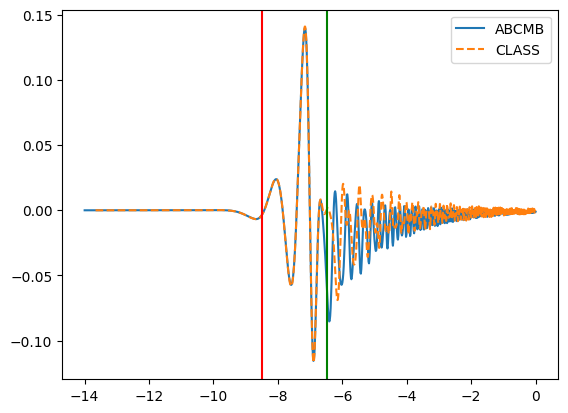

In [198]:
plt.plot(PT.lna, PT.Gg0[:, ki], label="ABCMB")
a = ks[ki][:, 1]
mode = ks[ki][:, 5]
plt.plot(jnp.log(a), mode, "--", label="CLASS")
plt.axvline(lna_tca_off,  color="red")
plt.axvline(lna_rsa_on, color="green")
#plt.xlim((-15., -7.0))
#plt.yscale("log")
plt.legend()
plt.show()

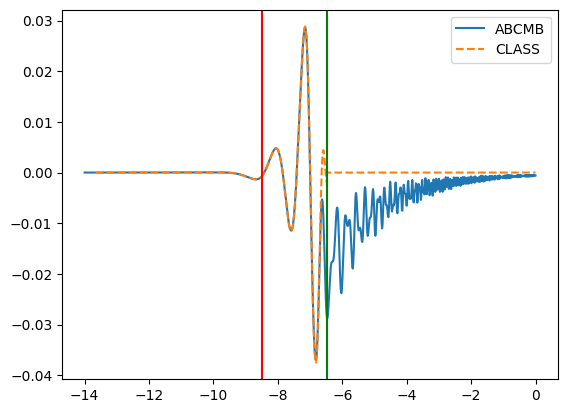

In [186]:
plt.plot(PT.lna, PT.Gg2[:, ki], label="ABCMB")
a = ks[ki][:, 1]
mode = ks[ki][:, 7]
plt.plot(jnp.log(a), mode, "--", label="CLASS")
plt.axvline(lna_tca_off,  color="red")
plt.axvline(lna_rsa_on, color="green")
#plt.xlim((-15., -7.0))
#plt.yscale("log")
plt.legend()
plt.show()

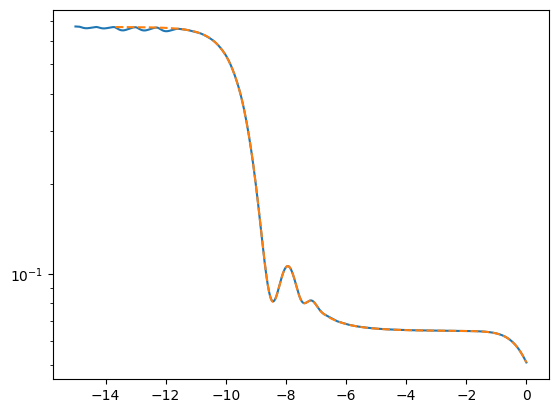

In [36]:
phi = PT.metric_eta[:, 0] - BG.aH(PT.lna)*PT.metric_alpha[:, 0]
psi = (PT.metric_alpha_prime[:, 0] + PT.metric_alpha[:, 0])*BG.aH(PT.lna)

plt.plot(PT.lna, abs(psi))
a = ks[-1][:, 1]
mode = ks[-1][:, 10]
plt.plot(jnp.log(a), abs(mode), "--")
#plt.xlim((-15., -7.0))
plt.yscale("log")
plt.show()

# Saving Output

In [76]:
def save_table(table: perturbations.PerturbationTable, filename: str):
    np.savez(
        filename,
        k=np.array(table.k),
        lna=np.array(table.lna),
        delta_cdm=np.array(table.delta_cdm),
        delta_b=np.array(table.delta_b),
        theta_b=np.array(table.theta_b),
        theta_b_prime=np.array(table.theta_b_prime),
        delta_g=np.array(table.delta_g),
        theta_g=np.array(table.theta_g),
        sigma_g=np.array(table.sigma_g),
        Gg0=np.array(table.Gg0),
        Gg2=np.array(table.Gg2),
        metric_h=np.array(table.metric_h),
        metric_eta=np.array(table.metric_eta),
        metric_h_prime=np.array(table.metric_h_prime),
        metric_eta_prime=np.array(table.metric_eta_prime),
        metric_alpha=np.array(table.metric_alpha),
        metric_alpha_prime=np.array(table.metric_alpha_prime),
    )

In [77]:
save_table(PT, "perturbations.npz")

In [78]:
MPT = perturbations.MockPerturbationTable()